# EE4375-2022: Fifth Lab Session: Galerkin Finite Element Method for the Poisson Equation on the Unit Interval

Solves the Poisson equation $- \frac{d^2 \, u(x)}{dx^2} = f(x)$ on the unit bar domain $x \in \Omega=(0,1)$ supplied with various boundary conditions and various source terms. The Galerkin finite element method is employed. This lab session complements the lectures with slides available at [shared drive](https://mega.nz/fm/CcsEnLxL). 

## Import Packages

In [182]:
using LinearAlgebra
using StructArrays
using StaticArrays
using Plots
using LaTeXStrings
using SparseArrays
using BenchmarkTools 

Matters to look further into: 
1. syntax of function returning multiple arguments; 
2. use @inbounds to remove bounds checking; 
3. for-loop using foreach; 
4. static arrays; 

## (Compulsory) Section 1/2: First Code 

One-dimensional FEM code.

<b> Remark 1</b>: in all codes that follows, the integer $N$ denotes the number of elements (or number of subdivision along the line) and the integer $Np1 = N+1$ denotes the number of nodes (or points on the line). Of these nodes, $N-1$ lie on the interior, while two other nodes are the left and right end point.  

<b> Remark 2</b>: in the first codes that follow, the global coefficient matrix $A$ is declared to be a dense (or fully populated) matrix. Given that in reality $A$ is sparse, this approach certainly is wasteful.  

Exercises: 
1. study the construction of the coefficient matrix;
2. study the construction of the right-hand side vector;
Use [Slides on the finite element method](https://mega.nz/file/nUkHUaDI#v0IJAIOV-Ql6c3gCL3UqqHheEdDE-vt7XX3fxmUGvKA)

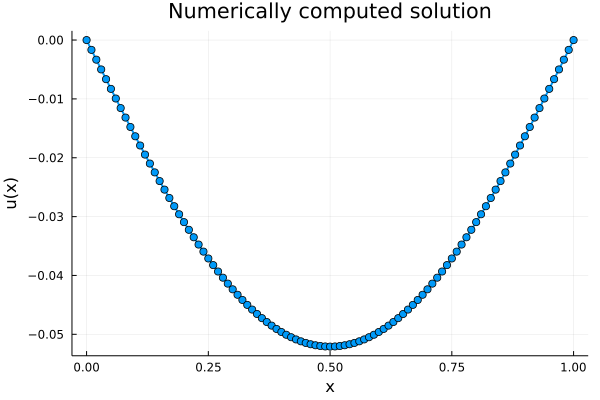

In [183]:
#..construct the mesh: see before 
N = 100; Np1 = N+1; h = 1/N
x = Vector(0:h:1)

#..Mesh with points and edges 
#..point holds the coordinates of the left and right node of the element
#..edges holds the global indices of the left and right node of the element
points = collect( [x[i], x[i+1]] for i in 1:N) 
edges = collect( [i, i+1] for i in 1:N) 

#..Set the source function 
fsource(x) = x*(x-1)

#..Initialize local and global matrix and right-hand side value 
floc = zeros(Float64,2, 1)
Aloc = zeros(Float64,2,2)
A = zeros(Float64,length(x), length(x))
f = zeros(Float64,length(x), 1) 

#..Perform loop over elements and assemble global matrix and vector 
for i=1:N 

  xl, xr = points[i,:][1]
  floc = (xr-xl) * [fsource(xl), fsource(xr)]
  Aloc = (1/(xr-xl))*[1 -1; -1 1]

  for j=1:2 
    f[edges[i][j]] += floc[j]
    for k =1:2 
      A[edges[i][j], edges[i][k]] += Aloc[j,k]
    end 
  end 

end

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;     A[1,2] = 0;        f[1]   = 0 
A[end,end-1]=0; A[end,end] = 1;    f[end] = 0

#..solve the linear system
u = A \ f

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")

## Section 2:/ Second Code: No Inner Double Loop Over the Nodes

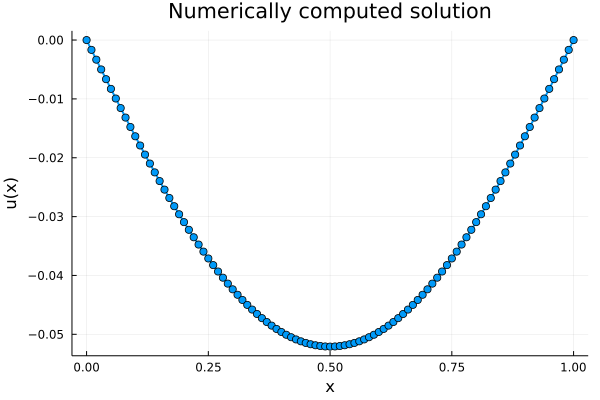

In [151]:
#..construct the mesh: see before 
N = 100; Np1 = N+1; h = 1/N
x = Vector(0:h:1) 

#..Mesh with points and edges 
#..point holds the coordinates of the left and right node of the element
#..edges holds the global indices of the left and right node of the element
points = collect( [x[i], x[i+1]] for i in 1:N) 
edges = collect( [i, i+1] for i in 1:N) 

#..Set the source function 
fsource(x) = x*(x-1)

#..Initialize global matrix and right-hand side value 
floc = zeros(Float64,2, 1)
Aloc = zeros(Float64,2,2)
A = zeros(Float64,length(x), length(x))
f = zeros(Float64,length(x), 1)

#..Perform loop over elements and assemble global matrix and vector 
for i=1:N 

  xl, xr = points[i,:][1]
  floc = (xr-xl) * [fsource(xl), fsource(xr)]
  Aloc = (1/(xr-xl))*[1 -1; -1 1]
  f[edges[i]] += floc
  A[edges[i], edges[i]] += Aloc

end

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;     A[1,2] = 0;        f[1]   = 0
A[end,end-1]=0; A[end,end] = 1;    f[end] = 0

#..solve the linear system
u = A \ f

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")

## Section 3:/ From Script to Function 
To be able to test efficiency (using @btime), type stability (using @code_warntype) and code generated (using @code_native). 

In [152]:
function fem_1d(N)
    
    if (Bool(0)) print(" [fem_1d]:: input N = ", N, "\n") end 
    
    Np1 = N+1; h = 1/N
    x = Vector(0:h:1) 

    #..Mesh with points and edges 
    #..point holds the coordinates of the left and right node of the element
    #..edges holds the global indices of the left and right node of the element
    points = collect( [x[i], x[i+1]] for i in 1:N) 
    edges = collect( [i, i+1] for i in 1:N) 

    #..Set the source function 
    fsource(x) = x*(x-1)

    #..Initialize global matrix and right-hand side value 
    floc = zeros(Float64,2, 1)
    Aloc = zeros(Float64,2,2)
    # A = zeros(Float64,Np1,Np1) 
    A = spzeros(Float64,Np1,Np1)
    f = zeros(Float64,length(x), 1)

    #..Perform loop over elements and assemble global matrix and vector 
    @inbounds for i=1:N 

      xl, xr = points[i,:][1]
      floc = (xr-xl) * [fsource(xl), fsource(xr)]
      Aloc = (1/(xr-xl))*[1 -1; -1 1]
      f[edges[i]] += floc
      A[edges[i], edges[i]] += Aloc

    end

    #..handle the boundary conditions in the matrix and right-hand side vector 
    A[1,1] = 1;     A[1,2] = 0;        f[1]   = 0
    A[end,end-1]=0; A[end,end] = 1;    f[end] = 0

    #..solve the linear system
    u = A \ f  
    
    return x, u 
    
end

fem_1d (generic function with 1 method)

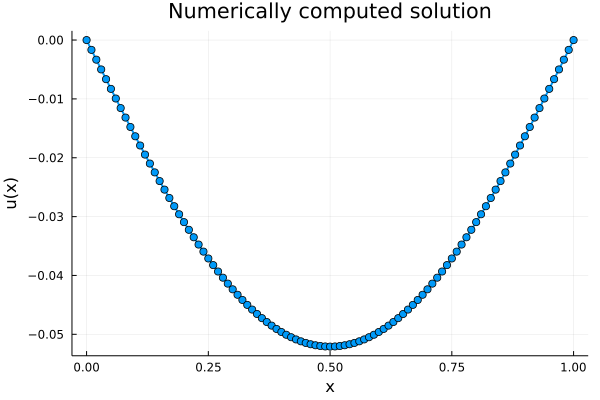

In [102]:
x,u = fem_1d(100) 

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")

In [205]:
#@code_native fem_1d(100)
#@code_warntype fem_1d(100)
@btime fem_1d(10000)

  603.886 ms (272081 allocations: 3.52 GiB)


([0.0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009  …  0.9991, 0.9992, 0.9993, 0.9994, 0.9995, 0.9996, 0.9997, 0.9998, 0.9999, 1.0], [0.0; -1.6666666501853565e-5; … ; -1.6666666499237764e-5; 0.0])

## Section 4:/ Using Sparse For Matrix Assembly  
Avoid using dense matrix and using structarray to store the mesh. 

In [202]:
# struct to hold single element
struct Element
  p1::Float64
  p2::Float64
  e1::Int64
  e2::Int64
end 

function fem_1d_sparse(N)
    
    if (Bool(0)) print(" [fem_1d]:: input N = ", N, "\n") end 
    
    #..Generate the mesh 
    Np1 = N+1; h = 1/N
    x = Vector(0:h:1) 
    mesh = StructArray{Element}((x[1:end-1], x[2:end], Vector(1:N), Vector(2:N+1)))

    if (Bool(0)) print(" [fem_1d]:: mesh = ", mesh, "\n") end

    #..Set the source function 
    fsource(x) = x*(x-1)

    #..Initialize global matrix and right-hand side value 
    f = zeros(Float64,Np1,1)
    I = zeros(Int64,4*N)
    J = zeros(Int64,4*N)
    Avalues = zeros(Float64,4*N)
    floc = zeros(Float64,2, 1)
    Aloc = zeros(Float64,2,2)

    #..Perform loop over elements and assemble global matrix and vector 
    @inbounds for i=1:N 
        
      xl = mesh[i].p1
      xr = mesh[i].p2
      j  = mesh[i].e1
      k  = mesh[i].e2
        
      floc = (xr-xl) * [fsource(xl), fsource(xr)];
      Aloc = (1/(xr-xl))*[1, -1, -1, 1]; 
        
      f[[j,k]] += floc 
      I[4*(i-1)+1:4*i] = [j, k, j, k]
      J[4*(i-1)+1:4*i] = [j, j, k, k]
      Avalues[4*(i-1)+1:4*i] = Aloc 
        
    end

    A = sparse(I,J,Avalues)

    #..handle the boundary conditions in the matrix and right-hand side vector 
    A[1,1] = 1;     A[1,2] = 0;        f[1]   = 0
    A[end,end-1]=0; A[end,end] = 1;    f[end] = 0

    #..solve the linear system
    u = A \ f  
    
    return x, u 
    
end

fem_1d_sparse (generic function with 1 method)

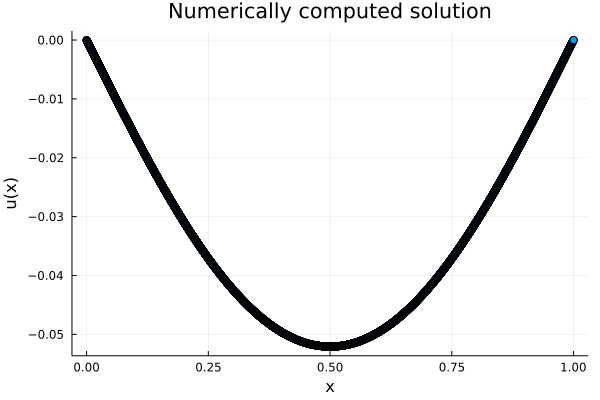

In [204]:
x,u = fem_1d_sparse(10000) 

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")

In [206]:
@btime fem_1d_sparse(10000)

  8.065 ms (90110 allocations: 21.98 MiB)


([0.0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009  …  0.9991, 0.9992, 0.9993, 0.9994, 0.9995, 0.9996, 0.9997, 0.9998, 0.9999, 1.0], [0.0; -1.6666666501853565e-5; … ; -1.6666666499237764e-5; 0.0])

## Section -1:/ Sandbox 